In [160]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader


amazon = pd.read_csv('AMAZON_daily.csv')
amazon=amazon[['Date', 'Close']]

apple = pd.read_csv('APPLE_daily.csv')
apple=apple[['Date', 'Close']]

google = pd.read_csv('GOOGLE_daily.csv')
google=google[['Date', 'Close']]

meta = pd.read_csv('META_daily.csv')
meta=meta[['Date', 'Close']]


netflix = pd.read_csv('NETFLIX_daily.csv')
netflix=netflix[['Date', 'Close']]

#my GPU is AMD Radeon (too complicated to use on my computer)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'



In [163]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df['Date'] = pd.to_datetime(df['Date'])

    #df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{n_steps+1-i})'] = df['Close'].shift(n_steps+1-i)

    df.dropna(inplace=True)

    return df

lookback=7
amazon_shift = prepare_dataframe_for_lstm(amazon, lookback)

apple_shift = prepare_dataframe_for_lstm(apple, lookback)

google_shift = prepare_dataframe_for_lstm(google, lookback)

meta_shift = prepare_dataframe_for_lstm(meta, lookback)

netflix_shift= prepare_dataframe_for_lstm(netflix, lookback)

netflix_shift

,Date,Close,Close(t-7),Close(t-6),Close(t-5),Close(t-4),Close(t-3),Close(t-2),Close(t-1)
7,2002-06-04,1.117857,1.196429,1.210000,1.157143,1.103571,1.071429,1.076429,1.128571
8,2002-06-05,1.147143,1.210000,1.157143,1.103571,1.071429,1.076429,1.128571,1.117857
9,2002-06-06,1.182143,1.157143,1.103571,1.071429,1.076429,1.128571,1.117857,1.147143
10,2002-06-07,1.118571,1.103571,1.071429,1.076429,1.128571,1.117857,1.147143,1.182143
11,2002-06-10,1.156429,1.071429,1.076429,1.128571,1.117857,1.147143,1.182143,1.118571
...,...,...,...,...,...,...,...,...,...
5771,2025-04-30,1131.719971,987.909973,1040.339966,1049.589966,1096.869995,1101.530029,1110.380005,1125.640015
5772,2025-05-01,1133.469971,1040.339966,1049.589966,1096.869995,1101.530029,1110.380005,1125.640015,1131.719971
5773,2025-05-02,1156.489990,1049.589966,1096.869995,1101.530029,1110.380005,1125.640015,1131.719971,1133.469971
5774,2025-05-05,1134.060059,1096.869995,1101.530029,1110.380005,1125.640015,1131.719971,1133.469971,1156.489990


In [176]:
amazon_np = amazon_shift.to_numpy() # won't show date column since data is index
amazon_np= np.hstack((amazon_np, np.ones((len(amazon_np),1))))
amazon_np = np.hstack((amazon_np, np.zeros((len(amazon_np), 4))))

apple_np = apple_shift.to_numpy()
apple_np = np.hstack((apple_np, np.zeros((len(apple_np), 1))))
apple_np = np.hstack((apple_np, np.ones((len(apple_np), 1))))
apple_np = np.hstack((apple_np, np.zeros((len(apple_np), 3))))

google_np = google_shift.to_numpy()
google_np = np.hstack((google_np, np.zeros((len(google_np), 2))))
google_np = np.hstack((google_np, np.ones((len(google_np), 1))))
google_np = np.hstack((google_np, np.zeros((len(google_np), 2))))

meta_np = meta_shift.to_numpy()
meta_np = np.hstack((meta_np, np.zeros((len(meta_np), 3))))
meta_np = np.hstack((meta_np, np.ones((len(meta_np), 1))))
meta_np = np.hstack((meta_np, np.zeros((len(meta_np), 1))))

netflix_np = netflix_shift.to_numpy()
netflix_np = np.hstack((netflix_np, np.zeros((len(netflix_np),4))))
netflix_np = np.hstack((netflix_np, np.ones((len(netflix_np), 1))))

shifted_np = np.vstack((amazon_np, apple_np, google_np, meta_np, netflix_np))


In [177]:
cutoff_date = np.quantile(shifted_np[:,0],0.95)
test_ind = shifted_np[:,0] >= cutoff_date
train_ind = shifted_np[:,0] < cutoff_date

shifted_np = np.delete(shifted_np, 0, 1)

In [221]:
from sklearn.preprocessing import MinMaxScaler

scalery = MinMaxScaler(feature_range=(-1,1)) #video said feature_range=(-1,1)
#this does std = (x-min)(max-min), x_new = std*(min-max)+min

shifted_np[:,0] = (scalery.fit_transform(shifted_np[:,0].reshape(-1,1))).reshape(-1)

scalerx = MinMaxScaler(feature_range=(-1,1))
shifted_np[:,1:lookback+1] = scalerx.fit_transform(shifted_np[:,1:lookback+1])



In [222]:
X =shifted_np[:,1:]
y=shifted_np[:,0]

In [223]:
split_ind = int(len(X)*0.95) #last 5% are for testing

#Spliting into train and test
X_train = X[train_ind]
X_test = X[test_ind]
y_train = y[train_ind]
y_test = y[test_ind]

#pytorch wants another dimension so:
X_train = (X_train.reshape((-1, lookback+5, 1))).astype(float)
X_test = (X_test.reshape((-1,lookback+5, 1))).astype(float)

y_train = (y_train.reshape((-1,1))).astype(float)
y_test = (y_test.reshape((-1,1))).astype(float)



In [224]:
#Wrap in tensors for pytorch
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

In [225]:
#Turn into dataset object (need custom class)
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X =X
        self.y =y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i): #square brackets indexing
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [226]:
#Wrap Datsets in DataLoaders to get batches

from torch.utils.data import DataLoader

batch_size=16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [227]:
##Building the model

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, lookback):
        super().__init__()
        self.hidden_size = hidden_size
        self.lookback =lookback
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size+5, 1)

    def forward(self, x):
        batch_size = x.size(0)
        #h0 is gate vectors, must initialize with particular shape
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x[:,:lookback],(h0, c0))
        temporary = torch.cat((out[:,-1,:], x[:, lookback:,0]), dim=1)
        out = self.fc(temporary)
        return out
    
model = LSTM(1,4,1, lookback)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=9, out_features=1, bias=True)
)

In [228]:
##Training function
def train_one_epoch():
    model.train(True) #set to training mode
    print(f'Epoch: {epoch+1}')
    running_loss=0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device) #gets a batch and puts on devide we use

        output = model(x_batch) #gets output of model
        loss = loss_function(output, y_batch) #compares outputs to ground truth
        running_loss += loss.item()
        optimizer.zero_grad() #zero out gradients
        loss.backward() #backward pass to calculate gradients
        optimizer.step() #slight step in direction of gradient

        if batch_index %1000 ==999: #prints every 100 batches
            avg_loss = running_loss/1000
            print('Batch {0}, Average Loss: {1:.10f}'.format(batch_index+1, avg_loss))

            running_loss=0.0 #reset back to 0
    print() #for a blank line space

In [229]:
##Validation function
def validate_one_epoch():
    model.train(False) #will not update weights
    running_loss=0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad(): #set to not update weights or change model
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss

    avg_loss = running_loss/len(test_loader)

    print('Validation loss:{0:.10f}'.format(avg_loss))
    print('**********************************************************') #looks good
    print() 

In [230]:
##Hyperparameters:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch() 
    validate_one_epoch()

Epoch: 1
Batch 1000, Average Loss: 0.0909835351

Validation loss:0.0398361385
**********************************************************

Epoch: 2
Batch 1000, Average Loss: 0.0002490233

Validation loss:0.0246516801
**********************************************************

Epoch: 3
Batch 1000, Average Loss: 0.0001357189

Validation loss:0.0161346532
**********************************************************

Epoch: 4
Batch 1000, Average Loss: 0.0000912445

Validation loss:0.0090166712
**********************************************************

Epoch: 5
Batch 1000, Average Loss: 0.0000644874

Validation loss:0.0070635406
**********************************************************

Epoch: 6
Batch 1000, Average Loss: 0.0000671134

Validation loss:0.0051548295
**********************************************************

Epoch: 7
Batch 1000, Average Loss: 0.0000672444

Validation loss:0.0045456067
**********************************************************

Epoch: 8
Batch 1000, Average Loss:

In [235]:
##graphing stuff
ind_am = ((X_train[:,7,0]==1).nonzero()).reshape(-1)
x_am = X_train[ind_am]

ind_ap = ((X_train[:,8,0]==1).nonzero()).reshape(-1)
x_ap = X_train[ind_ap]

ind_go = ((X_train[:,9,0]==1).nonzero()).reshape(-1)
x_go = X_train[ind_go]

ind_me = ((X_train[:,10,0]==1).nonzero()).reshape(-1)
x_me = X_train[ind_me]

ind_ne = ((X_train[:,11,0]==1).nonzero()).reshape(-1)
x_ne = X_train[ind_ne]


with torch.no_grad():
    predicted_am = model(x_am.to(device)).to('cpu').numpy() #numpy doesn't work on GPU
    predicted_ap = model(x_ap.to(device)).to('cpu').numpy()
    predicted_go = model(x_go.to(device)).to('cpu').numpy()
    predicted_me = model(x_me.to(device)).to('cpu').numpy()
    predicted_ne = model(x_ne.to(device)).to('cpu').numpy()


In [243]:
##Must inverse transform because normalized data
train_pred_am = scalery.inverse_transform(predicted_am)
y_train_am = scalery.inverse_transform(y_train[ind_am]) # Do the same for ground truth
#apple
train_pred_ap = scalery.inverse_transform(predicted_ap)
y_train_ap = scalery.inverse_transform(y_train[ind_ap])
#Google
train_pred_go = scalery.inverse_transform(predicted_go)
y_train_go = scalery.inverse_transform(y_train[ind_go])
#meta
train_pred_me = scalery.inverse_transform(predicted_me)
y_train_me = scalery.inverse_transform(y_train[ind_me])
#netflix
train_pred_ne = scalery.inverse_transform(predicted_ne)
y_train_ne = scalery.inverse_transform(y_train[ind_ne])

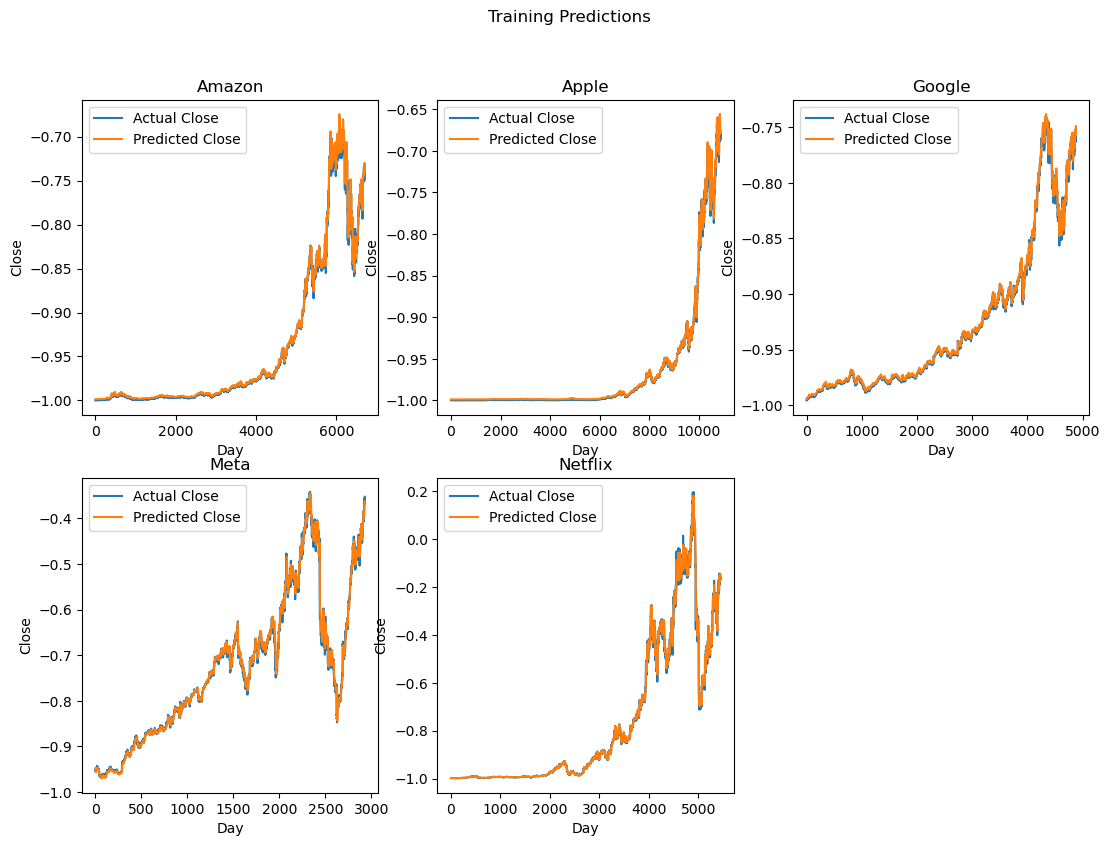

In [248]:
plt.figure(figsize=(13,9))
plt.subplot(2,3,1)
plt.plot(y_train_am, label='Actual Close')
plt.plot(train_pred_am, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Amazon')
plt.legend()
plt.subplot(2,3,2)
plt.plot(y_train_ap, label='Actual Close')
plt.plot(train_pred_ap, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Apple')
plt.legend()
plt.subplot(2,3,3)
plt.plot(y_train_go, label='Actual Close')
plt.plot(train_pred_go, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Google')
plt.legend()
plt.subplot(2,3,4)
plt.plot(y_train_me, label='Actual Close')
plt.plot(train_pred_me, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Meta')
plt.legend()
plt.subplot(2,3,5)
plt.plot(y_train_ne, label='Actual Close')
plt.plot(train_pred_ne, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Netflix')
plt.legend()
plt.suptitle('Training Predictions')
plt.show()

In [247]:
#now do this for testing (finding the proper scale)
ind_am_test = ((X_test[:,7,0]==1).nonzero()).reshape(-1)
x_am_test = X_test[ind_am_test]

ind_ap_test = ((X_test[:,8,0]==1).nonzero()).reshape(-1)
x_ap_test = X_test[ind_ap_test]

ind_go_test = ((X_test[:,9,0]==1).nonzero()).reshape(-1)
x_go_test = X_test[ind_go_test]

ind_me_test = ((X_test[:,10,0]==1).nonzero()).reshape(-1)
x_me_test = X_test[ind_me_test]

ind_ne_test = ((X_test[:,11,0]==1).nonzero()).reshape(-1)
x_ne_test = X_test[ind_ne_test]

#predicted_test_am = model(x_am_test.to(device)).detach().cpu().numpy().flatten() #from video
with torch.no_grad():
    predicted_test_am = model(x_am_test.to(device)).to('cpu').numpy() #numpy doesn't work on GPU
    predicted_test_ap = model(x_ap_test.to(device)).to('cpu').numpy()
    predicted_test_go = model(x_go_test.to(device)).to('cpu').numpy()
    predicted_test_me = model(x_me_test.to(device)).to('cpu').numpy()
    predicted_test_ne = model(x_ne_test.to(device)).to('cpu').numpy()

predicted_test_am = scalery.inverse_transform(predicted_test_am)
y_test_am = scalery.inverse_transform(y_test[ind_am_test])

predicted_test_ap = scalery.inverse_transform(predicted_test_ap)
y_test_ap = scalery.inverse_transform(y_test[ind_ap_test])

predicted_test_go = scalery.inverse_transform(predicted_test_go)
y_test_go = scalery.inverse_transform(y_test[ind_go_test])

predicted_test_me = scalery.inverse_transform(predicted_test_me)
y_test_me = scalery.inverse_transform(y_test[ind_me_test])

predicted_test_ne = scalery.inverse_transform(predicted_test_ne)
y_test_ne = scalery.inverse_transform(y_test[ind_ne_test])

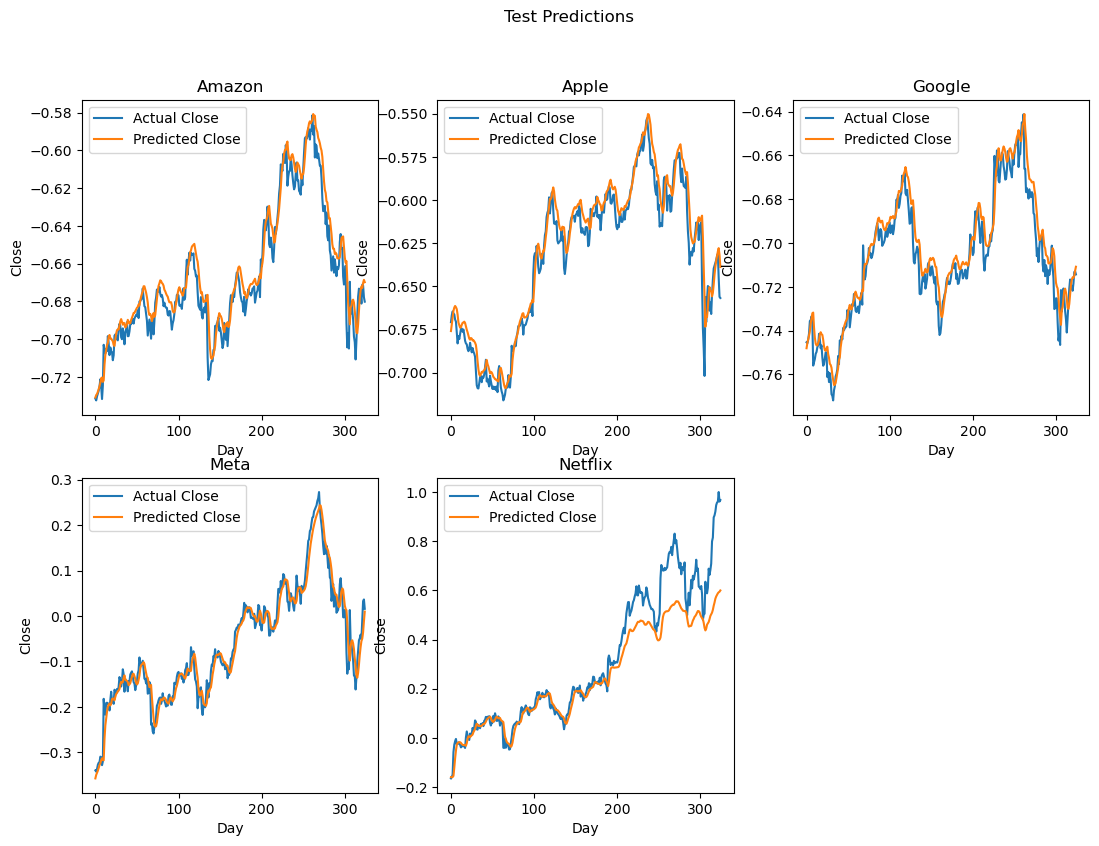

In [249]:
plt.figure(figsize=(13,9))
plt.subplot(2,3,1)
plt.plot(y_test_am, label='Actual Close')
plt.plot(predicted_test_am, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Amazon')
plt.legend()
plt.subplot(2,3,2)
plt.plot(y_test_ap, label='Actual Close')
plt.plot(predicted_test_ap, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Apple')
plt.legend()
plt.subplot(2,3,3)
plt.plot(y_test_go, label='Actual Close')
plt.plot(predicted_test_go, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Google')
plt.legend()
plt.subplot(2,3,4)
plt.plot(y_test_me, label='Actual Close')
plt.plot(predicted_test_me, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Meta')
plt.legend()
plt.subplot(2,3,5)
plt.plot(y_test_ne, label='Actual Close')
plt.plot(predicted_test_ne, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Netflix')
plt.legend()
plt.suptitle('Test Predictions')
plt.show()